### 1. juli

Arbeidstimer: 4t

Jeg skummet gjennom artikkelen https://arxiv.org/abs/2305.08746 som med BIMT-metoden undersøker hvordan man kan implementere nettverkene i rommet og la nevronene med de sterkeste vektene plasseres nærmere hverandre. Dette gjøres for å etterligne nettverkene i hjernen hvor det er en fordel at disse nevronene er nærme hverandre for å minke signaloverføringstiden og energien som brukes.

Artikkelen var veldig interessant og hadde facinerede visuelle plots som ga bedre forståelse. Dette er nok ikke noe jeg kommer til å se videre på med det første så forsatte med vektfordelingensprosjektet.

Fortsatte på koden jeg hadde begynt på 30. juni for å visualisere vektdifferansen mellom den første og andre epoken i ett av lagene til nettverket. Det viste seg å være vanskelig å gradvis øke bredden til bins i histogrammet.

Begynte å samle alle notebooks jeg hadde laget til nå i én notebook sammen med en forklaring på hva jeg har gjort de ulike dagene.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
# Hyperparameters
input_dim = 28**2  # MNIST images are 28x28 pixels
hidden_dim1 = 128  # Number of units in the first hidden layer
hidden_dim2 = 100  # Number of units in the second hidden layer
learning_rate = 0.01
output_dim = 10  # Initial output classes 
batch_size = 64

# Set random seed for reproducibility
torch.manual_seed(43)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        self.R = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.R(self.layer1(x))
        x = self.R(self.layer2(x))
        x = self.layer3(x)
        return x

In [4]:
# Normalizes the data like I did earlier by dividing by 255.0
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Create an instance of the network
model = Net()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [6]:
num_epochs = 2
# Track the weight differences
weight_differences = []
# Variables to store the initial and final weights
initial_weights = []
final_weights = []

# Training loop
for epoch in trange(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save the weights after the desired epochs
    if epoch == 0:
        initial_weights = model.layer1.weight.data.clone()
    elif epoch == num_epochs - 1:
        final_weights = model.layer1.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences.extend(weight_diff.view(-1).detach().numpy())

    print(f"Epoch [{epoch}/{num_epochs}]")


  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:14<00:14, 14.39s/it]

Epoch [0/2]


100%|██████████| 2/2 [00:33<00:00, 16.55s/it]

Epoch [1/2]


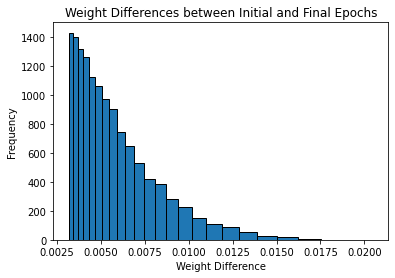

In [7]:
# Calculate the weight differences between the initial and final weights
weight_diffs = torch.abs(final_weights - initial_weights)

# Flatten the weight differences tensor and convert it to a NumPy array
weight_diffs_flat = weight_diffs.flatten().numpy()

# Plot the histogram with gradually increasing bin widths
bin_widths = np.logspace(-2.5, np.log10(np.max(weight_diffs_flat)), num=25)
plt.hist(weight_diffs_flat, bins=bin_widths, edgecolor="black")
plt.xlabel("Weight Difference")
plt.ylabel("Frequency")
plt.title("Weight Differences between Initial and Final Epochs")
plt.show()

Får ikke til å starte helt ved 0, det er et problem...

### 2. juli
Arbeidstimer: 4t

Det viste seg at å samle alle tidligere notebooks i én notebook var en dårlig idé da mange av de tidligere scriptene hadde like variabeler som gjorde den samlede notebooken tungvind å jobbe med. Lagde derfor et nytt datert system hvor hver notebook er navngitt etter datoen den ble jobbet med. Hver notebook inneholder en beskrivelse av hva som ble gjort hver av dagene og antall arbeidstimer (tidligere skrevet ned et annet sted).

Jobbet deretter videre med scriptet ovenfor for å prøve å implementere økende bredde på bins i histogrammet. Det fikk jeg til! Neste steg er plott av sannsynlighetstettheten.

### 3. juli
Arbeidstimer: 4t

Jobbet videre med å plotte sannsynlighetstettheten. Det viste seg å være vanskeligere enn først antatt i kombinasjon med en økende bredde på bins. Har ikke hatt statistikkemne før så måtte gjøre litt research på hvordan finne sannsynlighetstetthet. 

Andre ting å utforske:
- Lage histogram for hver tiende epoke?
- Se om det er forskjell i de ulike lagene
- Se mer på gradvis læringsmodellen, kan jeg kjøre den for flere epoker? parameterendring
- Plotte weight difference mot node index

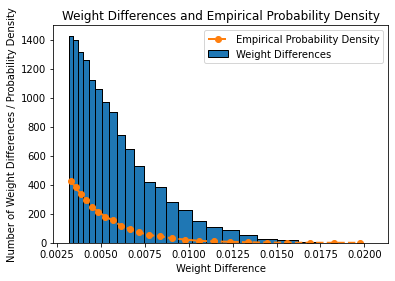

In [8]:
# Calculate the weight differences between the initial and final weights
weight_diffs = torch.abs(final_weights - initial_weights)

# Flatten the weight differences tensor and convert it to a NumPy array
weight_diffs_flat = weight_diffs.flatten().numpy()

# Plot the histogram with gradually increasing bin widths
bin_widths = np.logspace(-2.5, np.log10(np.max(weight_diffs_flat)), num=25)
counts, bins, _ = plt.hist(weight_diffs_flat, bins=bin_widths, edgecolor="black")

# Calculate the bin midpoints
bin_midpoints = (bins[:-1] + bins[1:]) / 2

# Calculate the bin widths
bin_widths = np.diff(bins)

# Calculate the empirical probability density
probability_density = counts / (np.sum(counts) * bin_widths)

# Plot the histogram with the weight difference counts
plt.bar(bins[:-1], counts, width=np.diff(bins), align="edge", edgecolor="black", label="Weight Differences")

# Plot the empirical probability density on top of the histogram
plt.plot(bin_midpoints, probability_density, "o--", linewidth=2, label="Empirical Probability Density")

plt.xlabel("Weight Difference")
plt.ylabel("Number of Weight Differences / Probability Density")
plt.title("Weight Differences and Empirical Probability Density")
plt.legend()
plt.show()

Prøver å bruke weight_differences som lagres inne i treningsloopen. Får da en sannsynlighetstetthet som ser riktigere ut, men nå må jeg øke bredden på bins igjen.

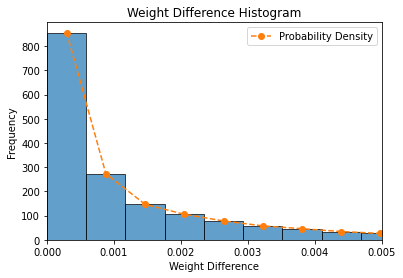

In [9]:
# Plot the histogram and probability density
plt.hist(weight_differences, bins=35, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram")

# Calculate probability density
hist, bin_edges = np.histogram(weight_differences, bins=35, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = np.diff(bin_edges)
prob_density = hist / (bin_widths * np.sum(hist))

# Plot probability density curve
plt.plot(bin_centers, prob_density, "o--", label="Probability Density")
plt.xlim(0, 0.005)
plt.legend()
plt.show()

Ser at når jeg lar bin edge starte fra 0 blir den første binnen veldig mye høyere for det er mange av vektendringene som er 0. Frequency er derimot lavere, er muligens noe feil i plottet ovenfor som gjør at det telles flere enn det faktisk er.

Prøver nå igjen å inkludere økende bin bredde

### 4. juli
Arbeidstimer: 8t

Har jobbet videre med vektendringsfordelingen og sannsynlighetstettheten. Fikk plottet både vektendringen og sannsynlighetstettheten for de tre ulike lagene og for endring i tid over 30 epoker. Man kan tydelig se at vektendringen minker etter tid. Det som jeg synes er merkelig er at uten endring i bin-vidde er sannysnlighetstetthetspunktene i samme høyde som hver bin, men med økende bin_width_scale får jeg ikke dette lenger til. Har brukt mye tid på å prøve å få det til uten hell... 

Histogrammene vil uansett vise hvilken fordeling vi har.

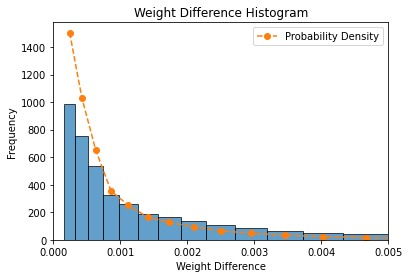

In [10]:
# Define the number of bins and the scaling factor for increasing bin widths
num_bins = 25
bin_width_scale = 15

# Calculate the scaling factor for each bin
bin_scaling = np.exp(np.linspace(0, np.log(bin_width_scale), num_bins))

# Calculate the bin edges
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1] # normalises the bin edges (0,1)
bin_edges *= np.max(weight_differences) # maps the normalized edges to the appropriate range of weight_diff

# Plot the histogram with custom bin widths
plt.hist(weight_differences, bins=bin_edges, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram")

# Calculate probability density
hist, _ = np.histogram(weight_differences, bins=bin_edges, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = np.diff(bin_edges)
prob_density = hist / (bin_widths * np.sum(hist))

# Plot probability density curve
plt.plot(bin_centers, prob_density, "o--", label="Probability Density")
plt.legend()
plt.xlim(0, 0.005)
plt.show()

Den første bin edgen starter ikke helt ved 0, mangler derfor mange counts, men har fått økende bin-bredde.

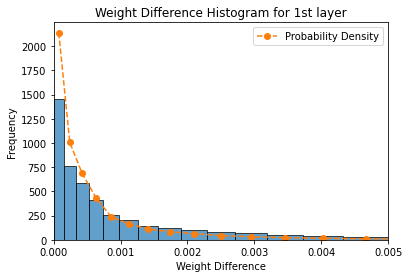

In [11]:
# Define the number of bins and the scaling factor for increasing bin widths
num_bins = 25
bin_width_scale = 15

# Calculate the scaling factor for each bin
bin_scaling = np.exp(np.linspace(0, np.log(bin_width_scale), num_bins))

# Insert 0 as the first element of bin_scaling
bin_scaling = np.insert(bin_scaling, 0, 0)

# Calculate the bin edges
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences)

# Plot the histogram with custom bin widths
plt.hist(weight_differences, bins=bin_edges, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram for 1st layer")

# Calculate probability density
hist, _ = np.histogram(weight_differences, bins=bin_edges, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = np.diff(bin_edges)
prob_density = hist / (bin_widths * np.sum(hist))

# Limit the probability density near zero
# prob_density[np.where(prob_density > hist)] = hist[np.where(prob_density > hist)]

# Plot probability density curve
plt.plot(bin_centers, prob_density, "o--", label="Probability Density")
plt.legend()
plt.xlim(0, 0.005)
plt.show()


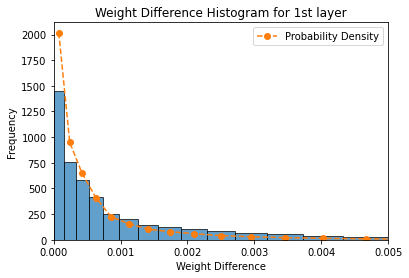

In [12]:
# Define the number of bins and the scaling factor for increasing bin widths
num_bins = 25
bin_width_scale = 15

# Calculate the scaling factor for each bin
bin_scaling = np.exp(np.linspace(0, np.log(bin_width_scale), num_bins))

# Insert 0 as the first element of bin_scaling
bin_scaling = np.insert(bin_scaling, 0, 0)

# Calculate the bin edges
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences)

# Plot the histogram with custom bin widths
plt.hist(weight_differences, bins=bin_edges, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram for 1st layer")

# Calculate probability density
hist, _ = np.histogram(weight_differences, bins=bin_edges, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the scaled bin widths
scaled_bin_widths = np.diff(bin_centers)

# Calculate the scaled histogram
scaled_hist = hist[:-1] / np.sum(hist[:-1])
scaled_hist /= scaled_bin_widths

# Plot probability density curve
plt.plot(bin_centers[:-1], scaled_hist, "o--", label="Probability Density")
plt.legend()
plt.xlim(0, 0.005)
plt.show()


TEST

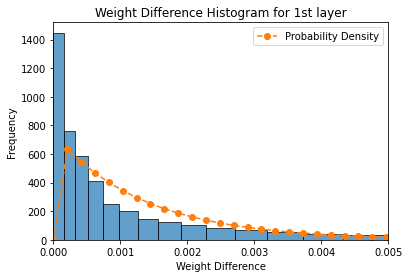

In [13]:
from scipy.stats import expon

# Define the number of bins and the scaling factor for increasing bin widths
num_bins = 25
bin_width_scale = 15

# Calculate the scaling factor for each bin
bin_scaling = np.exp(np.linspace(0, np.log(bin_width_scale), num_bins))

# Insert 0 as the first element of bin_scaling
bin_scaling = np.insert(bin_scaling, 0, 0)

# Calculate the bin edges
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences)

# Plot the histogram with custom bin widths
plt.hist(weight_differences, bins=bin_edges, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram for 1st layer")

# Fit the exponential distribution to the data
loc, scale = expon.fit(weight_differences)
x = np.linspace(0, np.max(weight_differences), 100)
pdf = expon.pdf(x, loc=loc, scale=scale)

# Plot the probability density curve
plt.plot(x, pdf, "o--", label="Probability Density")
plt.legend()
plt.xlim(0, 0.005)
plt.show()

Har endelig økende bin-bredder som starter ved 0 og sannsynlighetstetthet i samme plot!!

Prøver nå med de andre lagene:

In [14]:
# Track the weight differences
weight_differences = []
# Variables to store the initial and final weights
initial_weights = []
final_weights = []

# Training loop
for epoch in trange(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save the weights after the desired epochs
    if epoch == 0:
        initial_weights = model.layer2.weight.data.clone()
    elif epoch == num_epochs - 1:
        final_weights = model.layer2.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences.extend(weight_diff.view(-1).detach().numpy())

    print(f"Epoch [{epoch}/{num_epochs}]")

 50%|█████     | 1/2 [00:18<00:18, 18.61s/it]

Epoch [0/2]


100%|██████████| 2/2 [00:33<00:00, 16.56s/it]

Epoch [1/2]


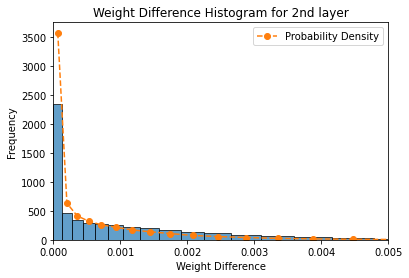

In [15]:
# Define the number of bins and the scaling factor for increasing bin widths
num_bins = 25
bin_width_scale = 15

# Calculate the scaling factor for each bin
bin_scaling = np.exp(np.linspace(0, np.log(bin_width_scale), num_bins))

# Insert 0 as the first element of bin_scaling
bin_scaling = np.insert(bin_scaling, 0, 0)

# Calculate the bin edges
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences)

# Plot the histogram with custom bin widths
plt.hist(weight_differences, bins=bin_edges, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram for 2nd layer")

# Calculate probability density
hist, _ = np.histogram(weight_differences, bins=bin_edges, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = np.diff(bin_edges)
prob_density = hist / (bin_widths * np.sum(hist))

# Plot probability density curve
plt.plot(bin_centers, prob_density, "o--", label="Probability Density")
plt.legend()
plt.xlim(0, 0.005)
plt.show()

In [16]:
# Track the weight differences
weight_differences = []
# Variables to store the initial and final weights
initial_weights = []
final_weights = []

# Training loop
for epoch in trange(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save the weights after the desired epochs
    if epoch == 0:
        initial_weights = model.layer3.weight.data.clone()
    elif epoch == num_epochs - 1:
        final_weights = model.layer3.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences.extend(weight_diff.view(-1).detach().numpy())

    print(f"Epoch [{epoch}/{num_epochs}]")

 50%|█████     | 1/2 [00:20<00:20, 20.21s/it]

Epoch [0/2]


100%|██████████| 2/2 [00:38<00:00, 19.14s/it]

Epoch [1/2]


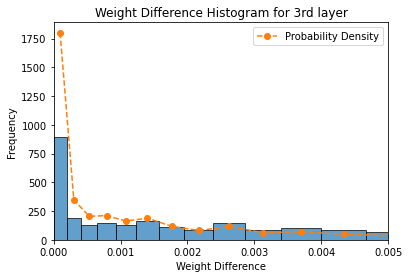

In [17]:
# Define the number of bins and the scaling factor for increasing bin widths
num_bins = 25
bin_width_scale = 15

# Calculate the scaling factor for each bin
bin_scaling = np.exp(np.linspace(0, np.log(bin_width_scale), num_bins))

# Insert 0 as the first element of bin_scaling
bin_scaling = np.insert(bin_scaling, 0, 0)

# Calculate the bin edges
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences)

# Plot the histogram with custom bin widths
plt.hist(weight_differences, bins=bin_edges, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram for 3rd layer")

# Calculate probability density
hist, _ = np.histogram(weight_differences, bins=bin_edges, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths = np.diff(bin_edges)
prob_density = hist / (bin_widths * np.sum(hist))

# Plot probability density curve
plt.plot(bin_centers, prob_density, "o--", label="Probability Density")
plt.legend()
plt.xlim(0, 0.005)
plt.show()

Now trying to see how the weight difference changes over time by training for a longer epoch. I will be looking at the first layer

In [18]:
num_epochs = 30

In [19]:
# Track the weight differences
weight_differences_0_1 = []
weight_differences_9_10 = []
weight_differences_29_30 = []
initial_weights = None

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save the weight differences for the desired epochs
    if epoch == 0:
        initial_weights = model.layer1.weight.data.clone()
    elif epoch == 1:
        final_weights = model.layer1.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_0_1.extend(weight_diff.view(-1).detach().numpy())
    elif epoch == 9:
        final_weights = model.layer1.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_9_10.extend(weight_diff.view(-1).detach().numpy())
    elif epoch == 29:
        final_weights = model.layer1.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_29_30.extend(weight_diff.view(-1).detach().numpy())

    print(f"Epoch [{epoch + 1}/{num_epochs}]")



Epoch [1/30]
Epoch [2/30]
Epoch [3/30]
Epoch [4/30]
Epoch [5/30]
Epoch [6/30]
Epoch [7/30]
Epoch [8/30]
Epoch [9/30]
Epoch [10/30]
Epoch [11/30]
Epoch [12/30]
Epoch [13/30]
Epoch [14/30]
Epoch [15/30]
Epoch [16/30]
Epoch [17/30]
Epoch [18/30]
Epoch [19/30]
Epoch [20/30]
Epoch [21/30]
Epoch [22/30]
Epoch [23/30]
Epoch [24/30]
Epoch [25/30]
Epoch [26/30]
Epoch [27/30]
Epoch [28/30]
Epoch [29/30]
Epoch [30/30]


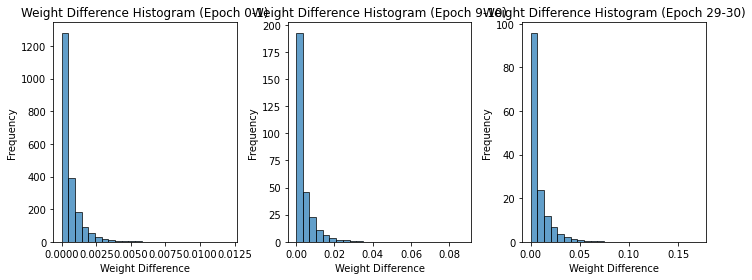

In [20]:
# Plot the histograms for each weight difference
plt.figure(figsize=(10, 4))
# Histogram for epoch 0-1
plt.subplot(1, 3, 1)
plt.hist(weight_differences_0_1, bins=25, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram (Epoch 0-1)")

# Histogram for epoch 9-10
plt.subplot(1, 3, 2)
plt.hist(weight_differences_9_10, bins=25, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram (Epoch 9-10)")

# Histogram for epoch 29-30
plt.subplot(1, 3, 3)
plt.hist(weight_differences_29_30, bins=25, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram (Epoch 29-30)")

plt.tight_layout()
plt.show()

Fikk ikke med sannsynlighetstetthetsgrafen i plottet, men ser at det blir færre vektendinger etterhvert som nettverket blir mer trent. Fordelingen av ulike vektendringer er derimot lik. Kan se at selv om det er færre endringer jo lengre man trener, blir endringene større.

Tester vektendringsfordelingen over tid mellom epoch 0-1, epoch 9-10 og epoch 29-30 for layer 1:

In [37]:
num_epochs = 30

# Track the weight differences
weight_differences_0_1 = []
weight_differences_9_10 = []
weight_differences_29_30 = []
initial_weights = None


In [38]:
# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save the weight differences for the desired epochs
    if epoch == 0:
        initial_weights = model.layer1.weight.data.clone()
    elif epoch == 1:
        final_weights = model.layer1.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_0_1.extend(weight_diff.view(-1).detach().numpy())
    elif epoch == 9:
        final_weights = model.layer1.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_9_10.extend(weight_diff.view(-1).detach().numpy())
    elif epoch == 29:
        final_weights = model.layer1.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_29_30.extend(weight_diff.view(-1).detach().numpy())

    print(f"Epoch [{epoch + 1}/{num_epochs}]")


Epoch [1/30]
Epoch [2/30]
Epoch [3/30]
Epoch [4/30]
Epoch [5/30]
Epoch [6/30]
Epoch [7/30]
Epoch [8/30]
Epoch [9/30]
Epoch [10/30]
Epoch [11/30]
Epoch [12/30]
Epoch [13/30]
Epoch [14/30]
Epoch [15/30]
Epoch [16/30]
Epoch [17/30]
Epoch [18/30]
Epoch [19/30]
Epoch [20/30]
Epoch [21/30]
Epoch [22/30]
Epoch [23/30]
Epoch [24/30]
Epoch [25/30]
Epoch [26/30]
Epoch [27/30]
Epoch [28/30]
Epoch [29/30]
Epoch [30/30]


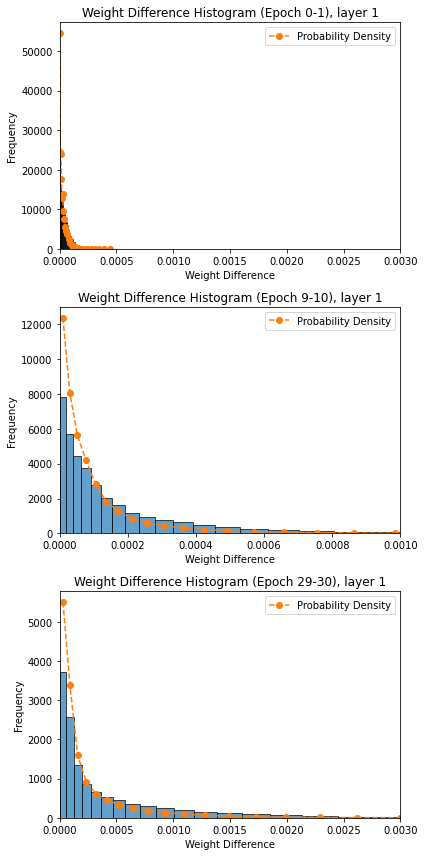

In [39]:
# Define the number of bins and the scaling factor for increasing bin widths
num_bins = 25
bin_width_scale = 15

# Calculate the scaling factor for each bin
bin_scaling = np.exp(np.linspace(0, np.log(bin_width_scale), num_bins))

# Insert 0 as the first element of bin_scaling
bin_scaling = np.insert(bin_scaling, 0, 0)

# Calculate the bin edges
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences_0_1)  # Use the maximum weight difference from epoch 0-1

# Plot the histograms for each weight difference
plt.figure(figsize=(6, 12))

# Plot the histogram with custom bin widths for epoch 0-1
plt.subplot(3, 1, 1)
plt.hist(weight_differences_0_1, bins=bin_edges, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.xlim(0, 0.003)
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram (Epoch 0-1), layer 1")

# Calculate probability density for epoch 0-1
hist_0_1, _ = np.histogram(weight_differences_0_1, bins=bin_edges, density=True)
bin_centers_0_1 = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths_0_1 = np.diff(bin_edges)
prob_density_0_1 = hist_0_1 / (bin_widths_0_1 * np.sum(hist_0_1))

# Plot probability density curve for epoch 0-1
plt.plot(bin_centers_0_1, prob_density_0_1, "o--", label="Probability Density")
plt.legend()

# Repeat the same process for epoch 9-10
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences_9_10)  # Use the maximum weight difference from epoch 9-10

# Plot the histogram with custom bin widths for epoch 9-10
plt.subplot(3, 1, 2)
plt.hist(weight_differences_9_10, bins=bin_edges, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.xlim(0, 0.001)
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram (Epoch 9-10), layer 1")

# Calculate probability density for epoch 9-10
hist_9_10, _ = np.histogram(weight_differences_9_10, bins=bin_edges, density=True)
bin_centers_9_10 = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths_9_10 = np.diff(bin_edges)
prob_density_9_10 = hist_9_10 / (bin_widths_9_10 * np.sum(hist_9_10))

# Plot probability density curve for epoch 9-10
plt.plot(bin_centers_9_10, prob_density_9_10, "o--", label="Probability Density")
plt.legend()

# Repeat the same process for epoch 29-30
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences_29_30)  # Use the maximum weight difference from epoch 29-30

# Plot the histogram with custom bin widths for epoch 29-30
plt.subplot(3, 1, 3)
plt.hist(weight_differences_29_30, bins=bin_edges, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.xlim(0, 0.003)
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram (Epoch 29-30), layer 1")

# Calculate probability density for epoch 29-30
hist_29_30, _ = np.histogram(weight_differences_29_30, bins=bin_edges, density=True)
bin_centers_29_30 = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths_29_30 = np.diff(bin_edges)
prob_density_29_30 = hist_29_30 / (bin_widths_29_30 * np.sum(hist_29_30))

# Plot probability density curve for epoch 29-30
plt.plot(bin_centers_29_30, prob_density_29_30, "o--", label="Probability Density")
plt.legend()

plt.tight_layout()
plt.show()

Her ser vi tydelig at når vi trener nettverket over lengre tid vil det være færre vektendringer.

Tester vektendringsfordelingen over tid mellom epoch 0-1, epoch 9-10 og epoch 29-30 for layer 2:

In [34]:
num_epochs = 30

# Track the weight differences
weight_differences_0_1 = []
weight_differences_9_10 = []
weight_differences_29_30 = []
initial_weights = None

In [35]:
# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Save the weight differences for the desired epochs
    if epoch == 0:
        initial_weights = model.layer2.weight.data.clone()
    elif epoch == 1:
        final_weights = model.layer2.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_0_1.extend(weight_diff.view(-1).detach().numpy())
    elif epoch == 9:
        final_weights = model.layer2.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_9_10.extend(weight_diff.view(-1).detach().numpy())
    elif epoch == 29:
        final_weights = model.layer2.weight.data.clone()
        weight_diff = torch.abs(final_weights - initial_weights)
        weight_differences_29_30.extend(weight_diff.view(-1).detach().numpy())

    print(f"Epoch [{epoch + 1}/{num_epochs}]")


Epoch [1/30]
Epoch [2/30]
Epoch [3/30]
Epoch [4/30]
Epoch [5/30]
Epoch [6/30]
Epoch [7/30]
Epoch [8/30]
Epoch [9/30]
Epoch [10/30]
Epoch [11/30]
Epoch [12/30]
Epoch [13/30]
Epoch [14/30]
Epoch [15/30]
Epoch [16/30]
Epoch [17/30]
Epoch [18/30]
Epoch [19/30]
Epoch [20/30]
Epoch [21/30]
Epoch [22/30]
Epoch [23/30]
Epoch [24/30]
Epoch [25/30]
Epoch [26/30]
Epoch [27/30]
Epoch [28/30]
Epoch [29/30]
Epoch [30/30]


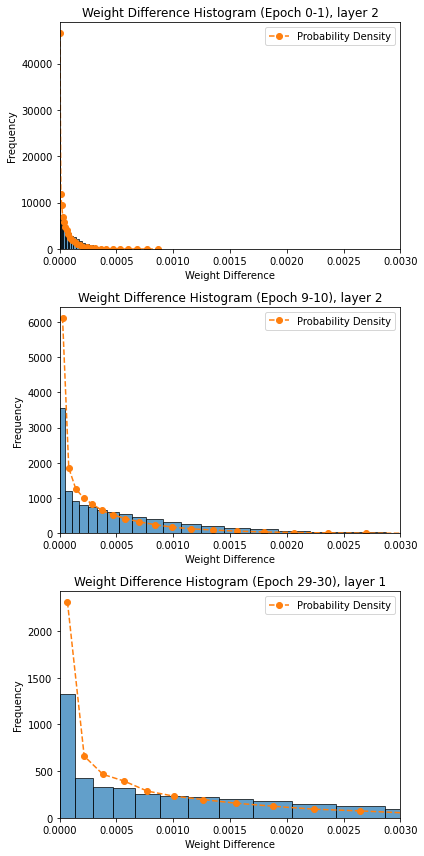

In [36]:
# Define the number of bins and the scaling factor for increasing bin widths
num_bins = 25
bin_width_scale = 15

# Calculate the scaling factor for each bin
bin_scaling = np.exp(np.linspace(0, np.log(bin_width_scale), num_bins))

# Insert 0 as the first element of bin_scaling
bin_scaling = np.insert(bin_scaling, 0, 0)

# Calculate the bin edges
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences_0_1)  # Use the maximum weight difference from epoch 0-1

# Plot the histograms for each weight difference
plt.figure(figsize=(6, 12))

# Plot the histogram with custom bin widths for epoch 0-1
plt.subplot(3, 1, 1)
plt.hist(weight_differences_0_1, bins=bin_edges, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.xlim(0, 0.003)
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram (Epoch 0-1), layer 2")

# Calculate probability density for epoch 0-1
hist_0_1, _ = np.histogram(weight_differences_0_1, bins=bin_edges, density=True)
bin_centers_0_1 = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths_0_1 = np.diff(bin_edges)
prob_density_0_1 = hist_0_1 / (bin_widths_0_1 * np.sum(hist_0_1))

# Plot probability density curve for epoch 0-1
plt.plot(bin_centers_0_1, prob_density_0_1, "o--", label="Probability Density")
plt.legend()

# Repeat the same process for epoch 9-10
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences_9_10)  # Use the maximum weight difference from epoch 9-10

# Plot the histogram with custom bin widths for epoch 9-10
plt.subplot(3, 1, 2)
plt.hist(weight_differences_9_10, bins=bin_edges, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.xlim(0, 0.003)
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram (Epoch 9-10), layer 2")

# Calculate probability density for epoch 9-10
hist_9_10, _ = np.histogram(weight_differences_9_10, bins=bin_edges, density=True)
bin_centers_9_10 = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths_9_10 = np.diff(bin_edges)
prob_density_9_10 = hist_9_10 / (bin_widths_9_10 * np.sum(hist_9_10))

# Plot probability density curve for epoch 9-10
plt.plot(bin_centers_9_10, prob_density_9_10, "o--", label="Probability Density")
plt.legend()

# Repeat the same process for epoch 29-30
bin_edges = np.cumsum(bin_scaling)
bin_edges /= bin_edges[-1]
bin_edges *= np.max(weight_differences_29_30)  # Use the maximum weight difference from epoch 29-30

# Plot the histogram with custom bin widths for epoch 29-30
plt.subplot(3, 1, 3)
plt.hist(weight_differences_29_30, bins=bin_edges, density=True, alpha=0.7, edgecolor="black")
plt.xlabel("Weight Difference")
plt.xlim(0, 0.003)
plt.ylabel("Frequency")
plt.title("Weight Difference Histogram (Epoch 29-30), layer 1")

# Calculate probability density for epoch 29-30
hist_29_30, _ = np.histogram(weight_differences_29_30, bins=bin_edges, density=True)
bin_centers_29_30 = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_widths_29_30 = np.diff(bin_edges)
prob_density_29_30 = hist_29_30 / (bin_widths_29_30 * np.sum(hist_29_30))

# Plot probability density curve for epoch 29-30
plt.plot(bin_centers_29_30, prob_density_29_30, "o--", label="Probability Density")
plt.legend()

plt.tight_layout()
plt.show()

Ser at det skjer totalt flere vektendringer i lag 2, men de er generelt lavere enn de i lag 1.